# 1 - Feature Extraction

### Loading required libraries

In [1]:
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import classification_report, accuracy_score

### Providing the path to the data

In [37]:
# variables 
# Note: labels should be always last column with name "labels"
# Note: Make sure input labels shapefile and input raster have same CRS, otherwise code will not run

# input files
#2015
#route = 'prueba/2015/RECORTE/'
#2017
#route = 'prueba/2017/RECORTE/'
#2019
#route = 'prueba/2019/RECORTE/'
#2021
#route = 'prueba/2021/RECORTE/'
#2023
route = 'prueba/2023/RECORTE/'
for i in range(3):
    MNDWI = route+'MNDWI.tif'
    NDVI = route+'NDVI.tif'
    FAI = route+'FAI.tif'
    
temp_point_loc = route+'points_TBC.shp'
#raster_loc = 'prueba/PruebaConversion.tif'
#points_loc = 'materials/shapefiles/samples.shp'


# land cover names (for post visualization)
lulc_name = ['water','building','vegetation','crops']#lulc_name = ['water','clouds','crops', 'road']
#lulc_name = ['crops', 'road', 'water']


### Loading  data

### Visualizing the data

In [19]:
#src = rio.open(raster_loc)

mndwi = rio.open(MNDWI).read(1, masked=True)
ndvi = rio.open(NDVI).read(1, masked=True)
fai = rio.open(FAI).read(1, masked=True)

## Tratamiento previo
"""
blue.data[blue.data<0] = 0
blue.data[np.isnan(blue.data)] = 0
np.ma.set_fill_value(blue,0)

green.data[green.data<0] = 0
green.data[np.isnan(green.data)] = 0
np.ma.set_fill_value(green,0)

red.data[red.data<0] = 0
red.data[np.isnan(red.data)] = 0
np.ma.set_fill_value(red,0)

nir.data[nir.data<0] = 0
nir.data[np.isnan(nir.data)] = 0
np.ma.set_fill_value(nir,0)
"""
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
#redn = normalize(red)
#greenn = normalize(green)
#bluen = normalize(blue)
#nirn = normalize(nir)

### Probe combinations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


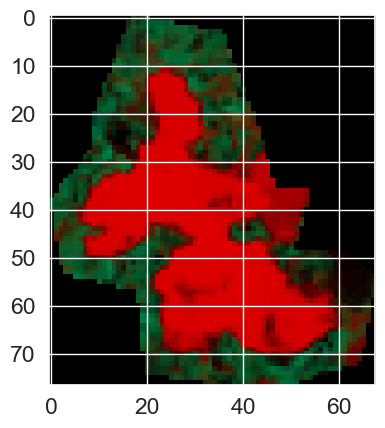

In [20]:
prgb = np.dstack((mndwi, ndvi, fai))

plt.imshow(prgb)

### False Color Composite Visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


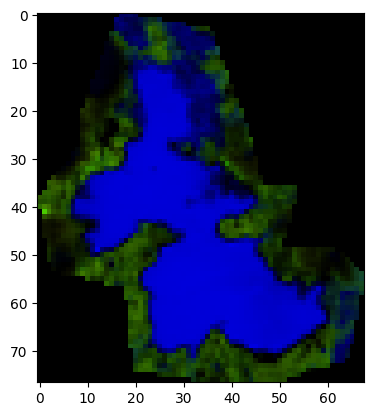

In [8]:
nrg = np.dstack((fai, ndvi, mndwi))

plt.imshow(nrg)

### Visualizing each bands

Text(0.5, 1.0, 'FAI')

C:\Users\JHON'T\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\colors.py:732: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
C:\Users\JHON'T\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


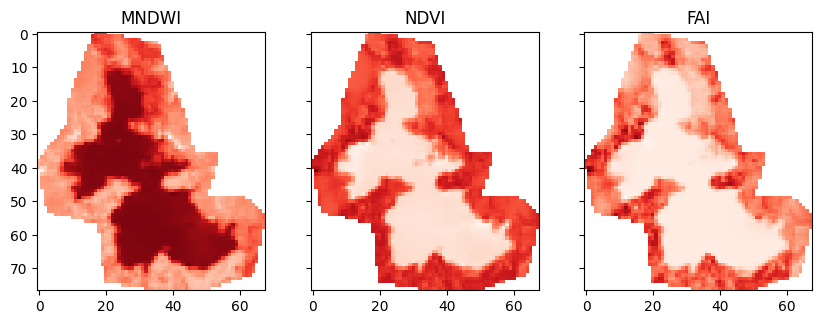

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# Initialize subplots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10, 4), sharey=True)

# Plot Red, Green and Blue (rgb)
ax1.imshow(mndwi, cmap='Reds')
ax2.imshow(ndvi, cmap='Reds')
ax3.imshow(fai, cmap='Reds')

# Add titles
ax1.set_title("MNDWI")
ax2.set_title("NDVI")
ax3.set_title("FAI")

In [38]:
band2_geo = rio.open(MNDWI).profile
band2_geo.update({"count": 3})
raster = 'prueba/2023/RECORTE/TBC.tiff'
with rio.open(raster, 'w', **band2_geo) as dest:
# I rearanged the band order writting to 2→3→4 instead of 4→3→2
    dest.write(mndwi,1)
    dest.write(ndvi,2)
    dest.write(fai,3)

In [14]:
#  reading bands from input
raster = 'prueba/2017/RECORTE/TBC.tiff'
with rio.open(raster) as img:
    bands = (img.read()).shape[0]
print('Bands of input image: ', bands)

# using ilteration to automatically create a bands list

features = []
for i in range(bands):
    features.append('band'+str(i+1))
print('Bands names: ', features)
features.append('type')
f_len = len(features)

# ilterating over multiband raster
sampled = pd.Series()

#inputShape= temp_point_loc
# Read input shapefile with fiona and iterate over each feature
with fiona.open(temp_point_loc) as shp:
    for feature in shp:
        siteID = feature['properties']['id']
        type = feature['properties']['type']
        coords = feature['geometry']['coordinates']
        
        # Read pixel value at the given coordinates using Rasterio
        # NB: `sample()` returns an iterable of ndarrays.
        with rio.open(raster) as stack_src:
                value = [v for v in stack_src.sample(coords)]
            
        # Update the pandas serie accordingly
        
        value[0] = value[0].tolist()
        value[0].append(lulc_name.index(type)+1)
        value[0] = np.array(value[0])
        sampled.loc[siteID] = value

# reshaping sampled values
df1 = pd.DataFrame(sampled.values.tolist(), index=sampled.index)
df1['id'] = df1.index
df1 = pd.DataFrame(df1[0].values.tolist(), 
                   columns=features)
df1['id'] = df1.index
data = df1
#data = pd.merge(df1, fiona.open(temp_point_loc)[:]['properties'], on ='id')
print('Sampled Data: \n',data)

x = data.iloc[:,0:bands]
X = x.values
y = data.iloc[:,-2]
Y = y.values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, stratify = Y)

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')


Bands of input image:  3
Bands names:  ['band1', 'band2', 'band3']
Sampled Data: 
        band1     band2     band3  type  id
0  -0.553687  0.797124  0.290287   4.0   0
1  -0.176026  0.535403  0.199123   4.0   1
2  -0.083385  0.522700  0.251289   4.0   2
3  -0.109778  0.401397  0.191853   4.0   3
4  -0.034090  0.462735  0.215918   4.0   4
5   0.007470  0.432412  0.188093   4.0   5
6  -0.553408  0.511342  0.129306   4.0   6
7  -0.142901  0.370837  0.172214   4.0   7
8   0.043059  0.393304  0.146699   4.0   8
9  -0.155051  0.383648  0.193889   4.0   9
10 -0.134066  0.185485  0.089803   3.0  10
11 -0.017904  0.114473  0.069380   3.0  11
12  0.127639  0.074928  0.012053   3.0  12
13  0.039201  0.005575 -0.008064   3.0  13
14  0.258828  0.091474  0.009576   3.0  14
15  0.363295 -0.053419 -0.027386   3.0  15
16  0.033354  0.047964  0.013618   3.0  16
17  0.236457  0.127504  0.020684   3.0  17
18 -0.096248  0.135521  0.050266   3.0  18
19  0.123768  0.065843  0.010372   3.0  19
20  0.375780 -

## Support Vector Machine (SVM)

Accuracy SVM: 91.66666666666666
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         3
         2.0       0.75      1.00      0.86         3
         3.0       1.00      0.67      0.80         3
         4.0       1.00      1.00      1.00         3

    accuracy                           0.92        12
   macro avg       0.94      0.92      0.91        12
weighted avg       0.94      0.92      0.91        12

Confusion Matrix RF: 
 [[3 0 0 0]
 [0 3 0 0]
 [0 1 2 0]
 [0 0 0 3]]


Text(48.65624999999999, 0.5, 'Actual')

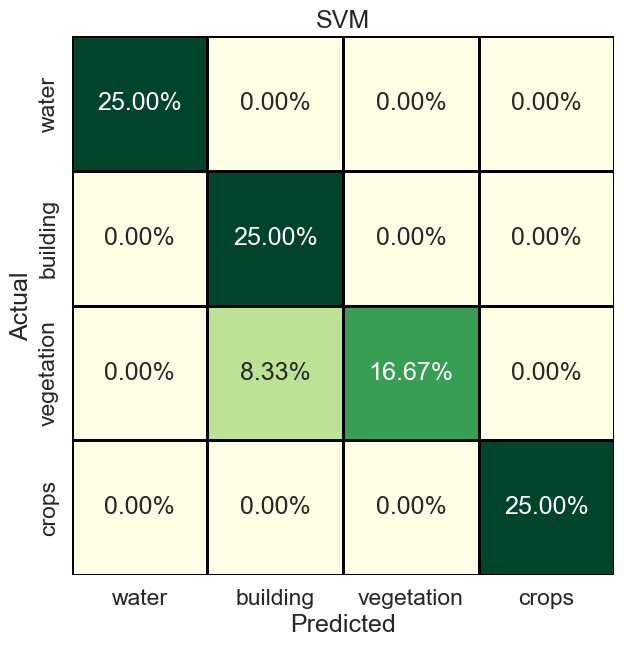

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
cName = 'SVM'
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

clf_pred = clf.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(f'../figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

## full data reshaping, predicting, and saving output

In [16]:
%%time
cName = 'SVM'
exp_name = f'prueba/2015/RECORTE/lulc_{cName}_TBC.tif'


img = rio.open(raster)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, bands)
print('reshaped full data shape  for prediction: ',img_n.shape)
metadata = img.meta
height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')


pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')

img_reshape = pred_full.reshape(height, width)

out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}.................')

Height: 77
Width: 68
Bands: 3

reshaped full data shape  for prediction:  (5236, 3)
Prediction Done, now exporting raster 

Map saved SVM.................
CPU times: total: 31.2 ms
Wall time: 30 ms


### 2017

In [23]:
%%time
cName = 'SVM'
exp_name = f'prueba/2017/RECORTE/lulc_{cName}_TBC.tif'

#2017
rasterio17 = 'prueba/2017/RECORTE/TBC.tiff'
#2019
rasterio19 = 'prueba/2019/RECORTE/TBC.tiff'
#2021
rasterio21 = 'prueba/2021/RECORTE/TBC.tiff'
#2023
rasterio23 = 'prueba/2023/RECORTE/TBC.tiff'

img = rio.open(rasterio17)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, bands)
print('reshaped full data shape  for prediction: ',img_n.shape)
metadata = img.meta
height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')


pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')

img_reshape = pred_full.reshape(height, width)

out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}.................')

Height: 77
Width: 68
Bands: 3

reshaped full data shape  for prediction:  (5236, 3)
Prediction Done, now exporting raster 

Map saved SVM.................
CPU times: total: 62.5 ms
Wall time: 62.1 ms


## Random Forest

Accuracy RF: 91.66666666666666
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         3
         2.0       0.75      1.00      0.86         3
         3.0       1.00      0.67      0.80         3
         4.0       1.00      1.00      1.00         3

    accuracy                           0.92        12
   macro avg       0.94      0.92      0.91        12
weighted avg       0.94      0.92      0.91        12

Confusion Matrix RF: 
 [[3 0 0 0]
 [0 3 0 0]
 [0 1 2 0]
 [0 0 0 3]]
CPU times: total: 188 ms
Wall time: 206 ms


Text(48.65624999999999, 0.5, 'Actual')

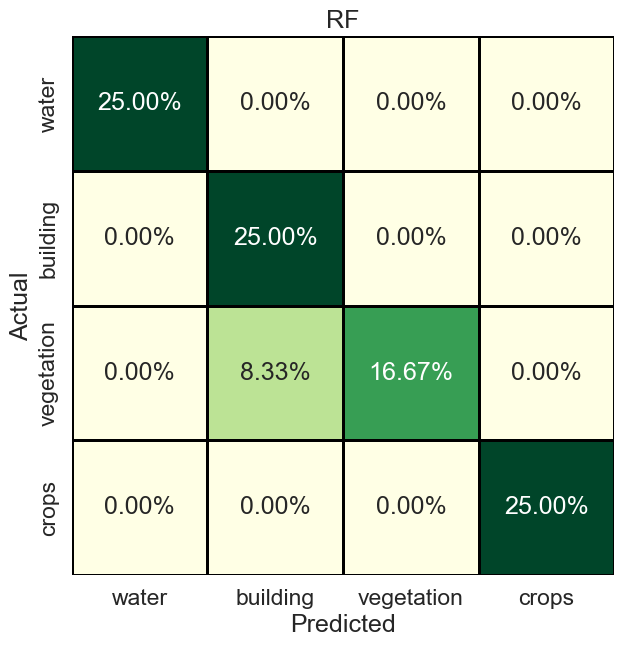

In [30]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

cName = 'RF'


clfr = RandomForestClassifier(random_state=42)
clfr.fit(X_train, y_train)

clf_pred = clfr.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(f'../figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

## full data reshaping, predicting, and saving output

In [31]:
%%time

cName = 'RF'
exp_name = f'prueba/2015/RECORTE/lulc_{cName}_TBC.tif'


img = rio.open(raster)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, bands)
print('reshaped full data shape  for prediction: ',img_n.shape)


pred_full = clfr.predict(img_n)

print('Prediction Done, now exporting raster \n')
# Predefining out raster meta using variable raster
tempfile_arr = img.read(1)
tempfile_arr = tempfile_arr.reshape(-1,1)
metadata = img.meta

height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')

img_reshape = pred_full.reshape(height, width)

out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}.................')

Height: 77
Width: 68
Bands: 3

reshaped full data shape  for prediction:  (5236, 3)
Prediction Done, now exporting raster 

Map saved RF.................
CPU times: total: 46.9 ms
Wall time: 54 ms


### 2017

In [ ]:
%%time

cName = 'RF'
exp_name = f'prueba/2015/RECORTE/lulc_{cName}.tif'


img = rio.open(raster)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, bands)
print('reshaped full data shape  for prediction: ',img_n.shape)


pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')
# Predefining out raster meta using variable raster
tempfile_arr = img.read(1)
tempfile_arr = tempfile_arr.reshape(-1,1)
metadata = img.meta

height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')

img_reshape = pred_full.reshape(height, width)

out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}.................')

## Decision Tree

Accuracy DT: 100.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         3
         2.0       1.00      1.00      1.00         3
         3.0       1.00      1.00      1.00         3
         4.0       1.00      1.00      1.00         3

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

Confusion Matrix RF: 
 [[3 0 0 0]
 [0 3 0 0]
 [0 0 3 0]
 [0 0 0 3]]
CPU times: total: 156 ms
Wall time: 138 ms


Text(48.65624999999999, 0.5, 'Actual')

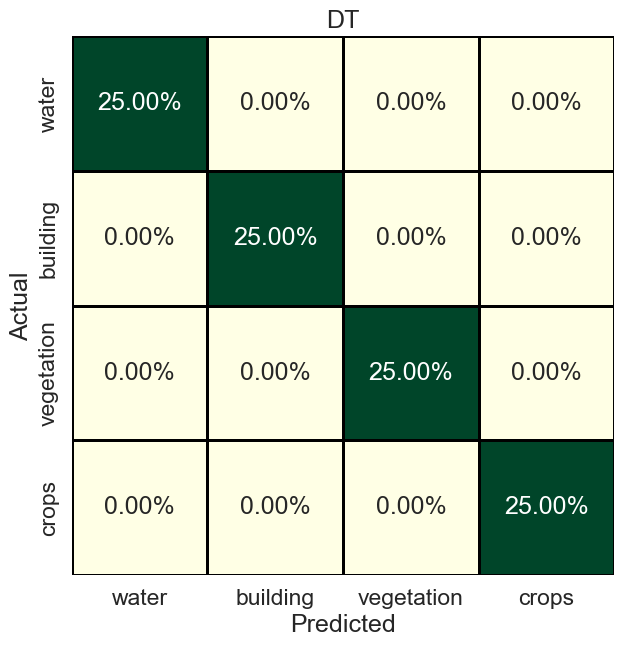

In [32]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

cName = 'DT'

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

clf_pred = clf.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(f'../figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

In [41]:
%%time

cName = 'DT'
exp_name = f'prueba/2023/RECORTE/lulc_{cName}_TBC.tif'

raster = 'prueba/2023/RECORTE/TBC.tiff'
img = rio.open(raster)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, bands)
print('reshaped full data shape  for prediction: ',img_n.shape)


pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')
# Predefining out raster meta using variable raster
tempfile_arr = img.read(1)
tempfile_arr = tempfile_arr.reshape(-1,1)
metadata = img.meta

height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')

img_reshape = pred_full.reshape(height, width)

out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}.................')

Height: 77
Width: 68
Bands: 3

reshaped full data shape  for prediction:  (5236, 3)
Prediction Done, now exporting raster 

Map saved DT.................
CPU times: total: 15.6 ms
Wall time: 23 ms


## Ensemble

Accuracy EN: 91.66666666666666
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         3
         2.0       0.75      1.00      0.86         3
         3.0       1.00      0.67      0.80         3
         4.0       1.00      1.00      1.00         3

    accuracy                           0.92        12
   macro avg       0.94      0.92      0.91        12
weighted avg       0.94      0.92      0.91        12

Confusion Matrix RF: 
 [[3 0 0 0]
 [0 3 0 0]
 [0 1 2 0]
 [0 0 0 3]]
CPU times: total: 109 ms
Wall time: 125 ms


Text(48.65624999999999, 0.5, 'Actual')

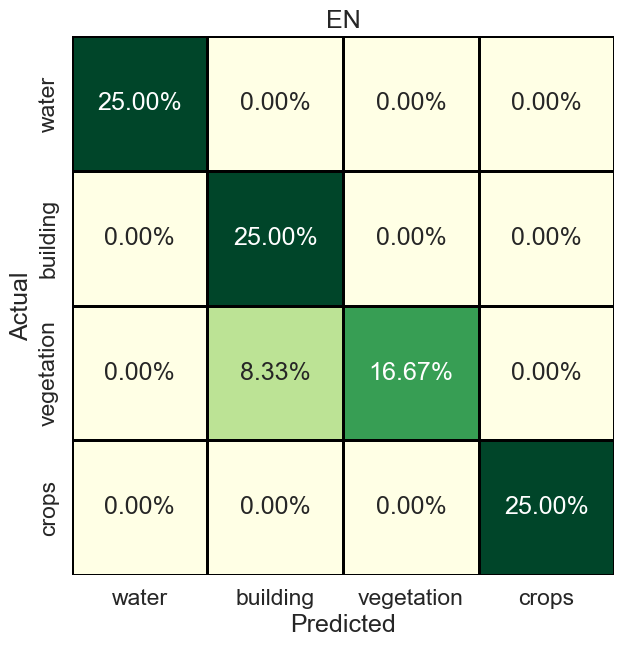

In [26]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix

cName = 'EN'

 # Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[2, 1, 2])

clf1 = clf1.fit(X_train, y_train)
clf2 = clf2.fit(X_train, y_train)
clf3 = clf3.fit(X_train, y_train)
eclf = eclf.fit(X_train, y_train)
#clf = DecisionTreeClassifier(random_state=42)
#clf.fit(X_train, y_train)

clf_pred = eclf.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))


# Confusion Matrix

cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(f'../figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

In [29]:
%%time

cName = 'EN'
exp_name = f'prueba/2015/RECORTE/lulc_{cName}_TBC.tif'

raster = 'prueba/2015/RECORTE/TBC.tiff'
img = rio.open(raster)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, bands)
print('reshaped full data shape  for prediction: ',img_n.shape)


pred_full = eclf.predict(img_n)

print('Prediction Done, now exporting raster \n')
# Predefining out raster meta using variable raster
tempfile_arr = img.read(1)
tempfile_arr = tempfile_arr.reshape(-1,1)
metadata = img.meta

height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')

img_reshape = pred_full.reshape(height, width)

out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}.................')

Height: 77
Width: 68
Bands: 3

reshaped full data shape  for prediction:  (5236, 3)
Prediction Done, now exporting raster 

Map saved EN.................
CPU times: total: 46.9 ms
Wall time: 48 ms


# 1 - Feature Extraction

In [46]:
exp_name = f'prueba/2015/RECORTE/lulc_{cName}_TBC.tif'

raster = 'prueba/2015/RECORTE/TBC.tiff'
img = rio.open(exp_name)
img_arr = img.read()
img_arr

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]], dtype=uint8)